# Data cleaning for SEER 1y incidence

In [120]:
import numpy as np
import pandas as pd
import os
os.getcwd() 

'c:\\repos\\pdac-calibration\\notebooks'

In [ ]:
seer_inc = pd.read_csv("../data/pdac_seer17_incidence_1y.csv")
seer_inc.iloc[:5]

In [122]:
# Pivot the data
pivot_df = seer_inc.pivot(
    index='Age recode with single ages and 85+', 
    columns='Combined Summary Stage (2004+)', 
    values='Crude Rate'
)

pivot_df.columns = [f"{col} Rate" for col in pivot_df.columns]
pivot_df.reset_index(inplace=True)
pivot_df = pivot_df[pivot_df['Age recode with single ages and 85+'] != 'Unknown']
pivot_df['Age'] = pivot_df['Age recode with single ages and 85+'].str[:2].astype(int)
pivot_df['Localized Rate'] = pivot_df['Localized Rate'].astype(float)
pivot_df['Regional Rate'] = pivot_df['Regional Rate'].astype(float)
pivot_df['Distant Rate'] = pivot_df['Distant Rate'].astype(float)
pivot_df['Unknown/unstaged Rate'] = pivot_df['Unknown/unstaged Rate'].astype(float)

In [123]:
pivot_df.drop(['nan Rate', 'In situ Rate', 'Blank(s) Rate', 'Age recode with single ages and 85+'], axis=1, inplace=True)

In [124]:
pivot_df.head()

,Distant Rate,Localized Rate,Regional Rate,Unknown/unstaged Rate,Age
0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,4


Redistribute unstaged cancer incidence over local, regional, and distant

In [125]:
pivot_df['Distant Rate'].iloc[4]

0.0

In [126]:
pivot_df['LRD Rate'] = pivot_df['Localized Rate'] + pivot_df['Regional Rate'] + pivot_df['Distant Rate']
pivot_df['LRDU Rate'] = pivot_df['Localized Rate'] + pivot_df['Regional Rate'] + pivot_df['Distant Rate'] + pivot_df['Unknown/unstaged Rate']
pivot_df['pLocal'] = pivot_df['Localized Rate'] / pivot_df['LRD Rate']
pivot_df['pRegional'] = pivot_df['Regional Rate'] / pivot_df['LRD Rate']
pivot_df['pDistant'] = pivot_df['Distant Rate'] / pivot_df['LRD Rate']
pivot_df['LocalU'] = pivot_df['Localized Rate'] + pivot_df['Unknown/unstaged Rate'] * pivot_df['pLocal']
pivot_df['RegionalU'] = pivot_df['Regional Rate'] + pivot_df['Unknown/unstaged Rate'] * pivot_df['pRegional']
pivot_df['DistantU'] = pivot_df['Distant Rate'] + pivot_df['Unknown/unstaged Rate'] * pivot_df['pDistant']

In [127]:
pivot_df = pivot_df[pivot_df['Age']>=20]
pivot_df = pivot_df[pivot_df['Age']<85]

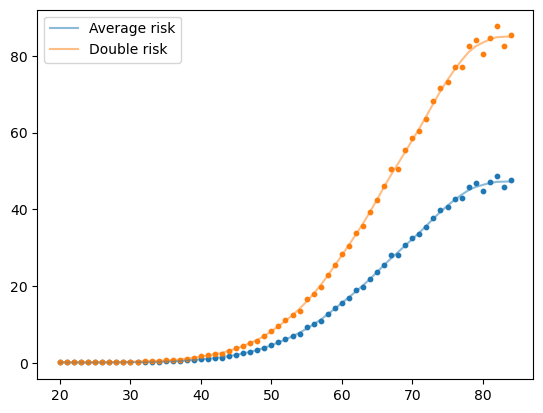

In [129]:
from csaps import csaps
import matplotlib.pyplot as plt

avg_risk = pivot_df.drop(columns=['Distant Rate', 'Localized Rate', 'Regional Rate', 'Unknown/unstaged Rate', 'LRD Rate'])
double_risk = pivot_df.copy()
double_risk['LRDU Rate'] = 1.8 * double_risk['LRDU Rate']

# Smooth the rates
avg_smooth = csaps(avg_risk['Age'], avg_risk['LRDU Rate'], smooth=0.3)(avg_risk['Age'])
double_smooth = csaps(double_risk['Age'], double_risk['LRDU Rate'], smooth=0.3)(double_risk['Age'])

# Plot
plt.plot(avg_risk['Age'], avg_smooth, linestyle="-", alpha=0.5, label="Average risk")
plt.scatter(avg_risk['Age'], avg_risk['LRDU Rate'], s=10)
plt.plot(double_risk['Age'], double_smooth, linestyle="-", alpha=0.5, label="Double risk")
plt.scatter(double_risk['Age'], double_risk['LRDU Rate'], s=10)
plt.legend()
plt.show()

In [130]:
avg_risk['LRDU Rate Smoothed'] = avg_smooth
avg_risk['LocalU'] = avg_risk['LRDU Rate Smoothed'] * avg_risk['pLocal']
avg_risk['RegionalU'] = avg_risk['LRDU Rate Smoothed'] * avg_risk['pRegional']
avg_risk['DistantU'] = avg_risk['LRDU Rate Smoothed'] * avg_risk['pDistant']

double_risk['LRDU Rate Smoothed'] = double_smooth
double_risk['LocalU'] = double_risk['LRDU Rate Smoothed'] * double_risk['pLocal']
double_risk['RegionalU'] = double_risk['LRDU Rate Smoothed'] * double_risk['pRegional']
double_risk['DistantU'] = double_risk['LRDU Rate Smoothed'] * double_risk['pDistant']

In [131]:
avg_risk.to_csv("../data/seer_incidence_1y.csv")
double_risk.to_csv("../data/seer_incidence_1y_double.csv")